In [6]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/images1/11.png
/kaggle/input/images1/3546.jpg_wh1200.jpg


In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import sys

In [4]:
def gram_matrix(input):
    b,c,h,w=input.size()
    features=input.view(b*c,h*w)
    G=torch.mm(features,features.t())
    return G.div(b*c*h*w)

class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        self.mean=torch.tensor(mean).view(-1,1,1).to(device)
        self.std=torch.tensor(std).view(-1,1,1).to(device)

    def forward(self,img):
        return (img-self.mean)/self.std

def loader(content_img_path,style_img_path,size):
    content_img=Image.open(content_img_path)
    style_img=Image.open(style_img_path)
    content_img=convert_mode(content_img)
    style_img=convert_mode(style_img)
    transform=transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
    content_img_rsz=transform(content_img)
    style_img_rsz=transform(style_img)
    imshow(content_img_rsz,title='Content Image')
    imshow(style_img_rsz,title='Style Image')
    content_img=content_img_rsz.unsqueeze(0).to(device)
    style_img=style_img_rsz.unsqueeze(0).to(device)
    return content_img,style_img

In [5]:
def imshow(image,title=None):
    image=image.clone().detach()
    image=image.squeeze(0)
    pil=transforms.ToPILImage()
    image=pil(image)
    plt.figure()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1)

def convert_mode(img):
    if img.mode=="RGB":
        return img
    elif img.mode=="RGBA":
        background=Image.new("RGB",img.size,(255, 255, 255))
        background.paste(img,mask=img.split()[3])
        return background

# Loss Classes
#content loss
class CL(nn.Module):
    def __init__(self,target):
        super(CL, self).__init__()
        self.target=target.detach()

    def forward(self, input):
        self.loss=F.mse_loss(input, self.target)
        return input
#style loss
class SL(nn.Module):
    def __init__(self,target):
        super(SL,self).__init__()
        self.target=gram_matrix(target).detach()

    def forward(self,input):
        G=gram_matrix(input)
        self.loss=F.mse_loss(G,self.target)
        return input

In [6]:
# Neural Style Transfer Model

def nst_model(content_img,style_img):
    vgg=models.vgg19(pretrained=True).features.eval().to(device)
    normalization=Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    content_losses=[]
    style_losses=[]

    model=nn.Sequential(normalization)
    i=0
    for name, layer in vgg._modules.items():
        if isinstance(layer, nn.Conv2d):
            model.add_module(f'conv_{i}',layer)
            if name in ['0','2','5','10']:
                target_feature=model(style_img).detach()
                style_loss=SL(target_feature)
                model.add_module(f'style_loss_{i}',style_loss)
                style_losses.append(style_loss)
            if name in ['7']:
                target_feature=model(content_img).detach()
                content_loss=CL(target_feature)
                model.add_module(f'content_loss_{i}',content_loss)
                content_losses.append(content_loss)
                print("content loss added!")
            i += 1
        if isinstance(layer, nn.ReLU):
            model.add_module(f'relu_{i}',nn.ReLU(inplace=False))
        if isinstance(layer, nn.MaxPool2d):
            model.add_module(f'pool_{i}',layer)

    return model,style_losses,content_losses

# Main Function

def main(args):
    content_img,style_img=loader(args.content_img,args.style_img,args.size)
    input_img=content_img.clone().to(device)
    content_img=content_img.to(device)
    model,style_losses,content_losses=nst_model(content_img,style_img)
    optimizer=optim.LBFGS([input_img.requires_grad_()])

    step=[0]
    while step[0]<=args.steps:
        def closure():
            input_img.data.clamp_(0,1)
            optimizer.zero_grad()
            model(input_img)

            style_score = sum([sl.loss for sl in style_losses])
            content_score = sum([cl.loss for cl in content_losses])
            loss = args.c_weight * content_score + args.s_weight * style_score
            loss.backward()

            step[0] += 1
            if step[0] % 200 == 0:
                print(f'Step {step[0]}:')
                print(f'Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}')
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    imshow(input_img, title='Output Image')
    plt.show()

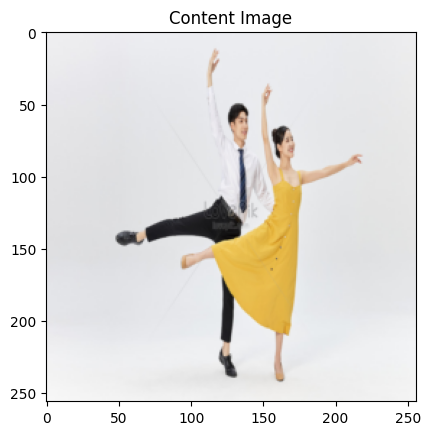

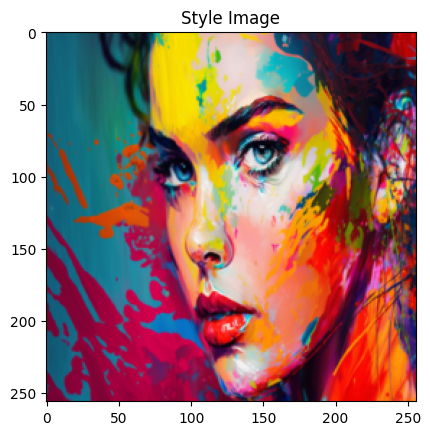

content loss added!
Step 200:
Style Loss: 0.000297 Content Loss: 45.967911
Step 400:
Style Loss: 0.000072 Content Loss: 40.656349


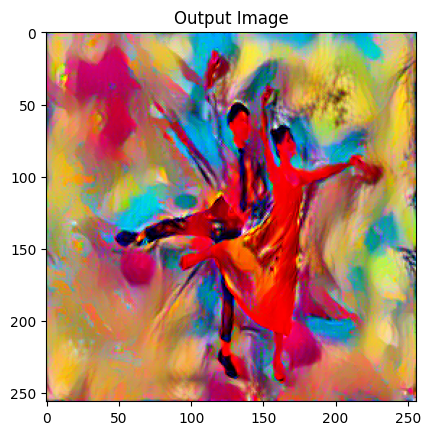

In [16]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--content_img', type=str, default='/kaggle/input/images2/Lena-Soederberg-256x256-JPEG-image-77-Kbytes.png')
    parser.add_argument('--style_img', type=str, default='/kaggle/input/images2/360_F_713442733_SM2b3dEN0nrbkUio6bwFLmfrIMDSuIia.jpg')
    parser.add_argument('--size', type=int, default=128, help='Size of the output image')
    parser.add_argument('--steps', type=int, default=300, help='Number of optimization steps')
    parser.add_argument('--c_weight', type=float, default=1, help='Weight for content loss')
    parser.add_argument('--s_weight', type=float, default=100000, help='Weight for style loss')

    if 'ipykernel' in sys.modules:
        # Default arguments for Jupyter Notebook
        class Args:
            content_img= '/kaggle/input/images1/3546.jpg_wh1200.jpg'
            style_img= '/kaggle/input/images1/11.png'
            size=256
            steps=400
            c_weight=1
            s_weight=100000

        args=Args()
        main(args)
    else:
        args=parser.parse_args()
        main(args)